# Report

## Group project for *Advanced topics in machine learning* lecture (2019)
#### Benjamin Ellenberger, Nicolas Deperrois, Laura Kriener

## Chosen Topic: **Music generation**

### **Motivation and State-of-the-Art**

The topics for the group project work was chosen in the very beginning of the course.
As it was announced that the course will nearly always use images for demonstrations, examples and excercises, we decided that our project should be on a different form of data.
We decided to work in the broad field of music generation with deep learing.

To narrow down the topic we investigated what the state of the art in this field is.
The most impressive recent results are produced by Google and OpenAI.
The [Google Magenta project](https://magenta.tensorflow.org/) covers a wide range of applications such as harmonization, drum-machines and a music generating network using the transformer network architecture with attention.

An other very recent result in the field of generating music was published by OpenAI. The [MuseNet](https://openai.com/blog/musenet/) uses the recently published GPT2-architecture which is a large-scale transformer network as well. 

The Google and OpenAI approaches as well as other (less famous) approaches have in common, that they employ very complicated network architectures in combination with the use of immense computational resources.

As the required computational power is far out of our reach, we wondered if this level of complexity is really unavoidable.
And so the question **How much can you do with how little?** became the leading theme for our project.
We want to see, what results can be achieved using much simpler network architecutres (i.e. architectures within the scope of the lecture)?
Which aspects of music generation can be achieved and which have to be ignored? For example can you generate a resonable melody line without considering the rhythm?

### Challenges
The main challenge is that music generation is a very broad topic. Before we can even start we have to answer a couple of questions:

- What exactly do we want to generate? Melody? Rhythm? Harmony?

This will depend on the network structures we try out. For example for simple feed-forward networks we only focus on melody, while we include rhythm in the LSTMs.

- How to feed music into a network? Spectrum? Pitches? Intervals?

We will not use spectrum or audio-data, instead we will work with pitches and intervals and note-lengths extracted from midi-files.

- What kind of music?

As we try to keep things as simple as possible, we decided to use the widely used bach chorale data-set (see `data/raw/bach`).

- How do we evaluate the result?

Music and the quality of music is a highly subjective topic. It is very difficult to find a metric that evaluates how good a produced piece of music is.
We plan to evaluate the pieces of music produced by the different network architectures by comparison and by the networks ability to capture different aspects of music (e.g. if one architecture can only produce melodies without considering rhythm and the other includes rhythm the second one is better suited for music generation). Additionally a measure for quality can be the similarity to the music style it was trained on. 

### Data sets

We will work on the Bach chorale dataset which we included in the repository (see `data/raw/bach`).
Midi-files are binary, therefore it is difficult to modify and create them directly.
We are using the python libaries `pianoroll` and `midicsv` which translates a midi-file into a human-readable (and modifiable) csv-string.
From this we have written our own utility functions that allow us to extract high-level information about the music (e.g. tempo, tonality) and perform changes to the tracks and write them back to a midi file. The utility functions are located in the file `src/midi_utils.py`. A demonstration on how to use them can be found in the notebook `demo_midi_utils.ipynb`. The functions to create a Pytorch compatible dataset from the midi-data are in the file `src/dataset_utils.py`.

### **Feed-Forward Networks**

Starting from the simplest possible network architecture, we will first investigate the potential and limitations of feed-forward networks.
Their architecture is not really suited to deal with time-series data, because one input sample is presented as a whole and at the same time to the network.
Also there is no mechanism for memory of the past.
Respecting these limitations, we simplify the task of "music generation" to **predicting the next note in a melody given the $n$ previous notes** (we only predict the pitch not the length of notes).

#### Generation mechanism

This setup also allows for a generation mechanism for a longer melody as sketched in the figure below:
We start the network of with a set of notes from a melody ($n1$ to $n10$) as input. 
The network then predicts the next note for the melody ($n11$). In the next step we give the network a new set of input which consists of the notes $n2$ to $n10$ **and** the note it predicted before $n11$. The network now predicts the twelth note ($n12$) which is then used in the input for the next round.

The main goal of this generation task is to produce a series of notes which is not dissonant and stays in the tonality of the given starter notes.


![Schematic drawing of generation procedure](graphics/forward3.png)


#### Network structure

The figure below shows a sketch of the feed-forward architecture that produced the best results.
Note that the inputs for the network are not the pitches of the starter-notes but the intervals between them.
This is beneficial, as using the intervals automatically provides a form of normalization.
The use of intervals for example removes for example the dependence on the key the melody is written in.
For example the line C-D-E-F (C-Major) will produce `[2, 2, 2, 1]` (counting the intervals in half-tone steps).
Even though the line D-E-F#-G (D-Major) is in a different key, it will produce the same intervals `[2, 2, 2, 1]`.

The input layer of the network contains 10 units, each coding for one of the ten starter-intervals.
The input is connected to two hidden layer with 128 units each.
The output layer has 25 units. Each is coding for one possible interval (step-size: half-tones) in the range of $\pm$ 1 Octave.
We train the network by presenting it with 10-intervals pieces of the bach dataset and let it predict the 11th interval.
The loss is calculated using the CrossEntropyLoss-function in pyTorch.
In early experiments the output layer contained only one unit which was used to predict the pitch/interval value. 
The results were much worse compared to predicting the probability for each possible interval. 
In the generation mode of the network the interval with the highest probability is picked as the "chosen interval" by the network.

![Feed-forward architecture](graphics/forward2.png)

#### Results

![Feed-forward architecture](graphics/loss_forward_intervals.png)

The figure above shows the training process of the described network architecture.
We see a clear occurance of overfitting, as the loss on the validation dataset first plateaus and then increases while the loss on the training data continues to decrease.
The 3 stars in the plot mark where snapshots of the network model were taken during training and saved for the generation of melodies.
The notebook cells below show an exemplary melody generated by an untrained network, by the network at the end of the plateau in the validation loss and at the end of training, when the validation loss has already increased again.
For the generation of the audio samples below the same 10 starter-notes were used.
They are included in the audio file.


##### **Alternative architectures / training methods and their impact**
In the following we quickly describe some different variations of the described network architecture and why they were dismissed in favor of the one presented above.

- more neurons/layers: lead to worse overfitting without increasing performance significantly
- less neurons/layers: delay the overfitting but decrease performance
- regularization methods: only delay overfitting while decreasing performance
- more starter-notes (i.e. larger input layer): worse overfitting
- less starter-notes (everything below 10): decreases overfitting but during generation the network will just produce a repeated loop of the starter-notes


#### Audio sample of untrained network
We had to stop the generation of this melody early because the notes predicted by the network drifted out of the available range in midi-files.
The untrained network clearly does not stay in a fairly small pitch range (as Bach melodies usually do) and produces lines that sound unharmonic.

In [1]:
import pygame

filename = 'results/feedforward_net_track_intervals_untrained.mid'
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
pygame.mixer.music.stop()

#### Audio sample of the network at the end of training
The melody produced by this network stays within a reasonable pitch range of the starter notes.
It produces a harmonic sounding line of notes and seems to stay within the tonality of the starter notes.

In [3]:
import pygame

filename = 'results/feedforward_net_track_intervals.mid'
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [4]:
pygame.mixer.music.stop()

#### Audio sample of network before severe overfitting
The melody produced by this network stays within a reasonable pitch range of the starter notes.
It produces a mostly harmonic sounding line of notes and mostly seems to stay within the tonality of the starter notes.
There are some questionable choices of notes in the melody

In [6]:
import pygame

filename = 'results/feedforward_net_track_intervals_snapshot.mid'
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [7]:
pygame.mixer.music.stop()

### Discussion of results
Bearing in mind that we chose the feed-forward architecture as the most simple model, we can be content with the result. 
It was clear from the start that the feed-forward networks would only be able to learn a very restricted task, i.e. no rhythm and chords.
Therefore we chose only to try to learn to produce short melody patches. This we were able to achieve.
The overfitting which occured is a problem, that might be alieviated by a larger dataset. However, the larger sets available do contain different styles of music than Bach chorales which we deliberatly chose for their simple melody lines.

We see that both trained snapshots of the network produce a melody that stays within a reasonable range of notes and does not drift off like the untrained version.
Also they produce lines of notes that are consistent with the harmony style by Bach and they mostly stay within the tonality.

One could argue that using the network which was trained with heavy overfitting is ok for music generation (but not for predicting the next note of a melody line), because it effectively does what a human composer does: It "knows" short patches of melody from the training set (i.e. the music it already knows) and reuses parts of these melody patches to generate new melodies. Human composes do this as well (a lot). For example, someone who knows a couple of Hans Zimmer movie soundtracks will very quickly recognize if a new soundtrack is written by Hans Zimmer, because he very often reuses certain themes and instrumentation schemes.

### Exemplary usage of the code
#### Training the network model and generating with it

In [11]:
import os
import copy
import torch
import src.feed_forward_utils as ff
import matplotlib.pyplot as plt
%matplotlib inline

try:
    home_dir
except NameError:
    home_dir = os.getcwd()
os.chdir(home_dir)

data_dir = '/data/raw/bach'

minibatch_size = 32
train_valid_ratio = 0.8        # size ratio of the train- and validation dataset
feature_qty = 10               # how many starter-intervals are presented to network
prediction_qty = 1             # must be one if intervals are used
interval_range = [-12, 12]     # in halftones -> 1 octave
snapshot_epoch = 50            # epoch at which a snapshot of the model is created during training
n_epochs = 100
learning_rate = 0.001
hidden_size = 128

tracks = ff.load_tracks(data_dir, 1)
train_set, valid_set, train_loader, valid_loader = ff.generate_dataloaders(tracks, minibatch_size, train_valid_ratio, 
                                                                           feature_qty, prediction_qty, interval_range)
input_size = len(train_set[0][0])   # get input size
input_example = train_set[0][0]
output_size = len(range(interval_range[0], interval_range[1]+1, 1))     # get output size
output_example = train_set[0][1]
print("Training set size", len(train_set))
print("Input size {}/ output size {}/ learning rate {}".format(input_size, output_size, learning_rate))
print("Input example {}".format(input_example))
print("Output example (idx of next interval) {}".format(output_example))

Loaded 357 tracks
Mean of the dataset: 0.00045936931473620525
Number of samples: 16490
Training set size 13192
Input size 10/ output size 25/ learning rate 0.001
Input example tensor([-0.3333,  0.1667,  0.1667, -0.3333, -0.0833, -0.1667,  0.5833,  0.0000,
        -0.1667,  0.4167])
Output example (idx of next interval) 9


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
forward_model = ff.FeedForward(input_size, hidden_size, output_size)
untrained_model = copy.deepcopy(forward_model)
untrained_model = untrained_model.to(device)
forward_model = forward_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forward_model.parameters(), lr=learning_rate)

In [13]:
train_losses, val_losses, snapshot_model = ff.train(forward_model, train_loader, valid_loader, 
                                                    optimizer, n_epochs, criterion, device=device, 
                                                    verbose=True, snapshot=snapshot_epoch)

Epoch 1/100: train_loss: 2.1387, val_loss: 2.0497
Epoch 2/100: train_loss: 2.0236, val_loss: 1.9717
Epoch 3/100: train_loss: 1.9757, val_loss: 1.9382
Epoch 4/100: train_loss: 1.9338, val_loss: 1.9056
Epoch 5/100: train_loss: 1.9032, val_loss: 1.8816
Epoch 6/100: train_loss: 1.8697, val_loss: 1.8396
Epoch 7/100: train_loss: 1.8307, val_loss: 1.8304
Epoch 8/100: train_loss: 1.7942, val_loss: 1.7759
Epoch 9/100: train_loss: 1.7642, val_loss: 1.7558
Epoch 10/100: train_loss: 1.7381, val_loss: 1.7398
Epoch 11/100: train_loss: 1.7225, val_loss: 1.7183
Epoch 12/100: train_loss: 1.7059, val_loss: 1.7324
Epoch 13/100: train_loss: 1.6932, val_loss: 1.7198
Epoch 14/100: train_loss: 1.6780, val_loss: 1.7065
Epoch 15/100: train_loss: 1.6632, val_loss: 1.7003
Epoch 16/100: train_loss: 1.6505, val_loss: 1.7124
Epoch 17/100: train_loss: 1.6403, val_loss: 1.7409
Epoch 18/100: train_loss: 1.6274, val_loss: 1.6992
Epoch 19/100: train_loss: 1.6155, val_loss: 1.7140
Epoch 20/100: train_loss: 1.6109, val_lo

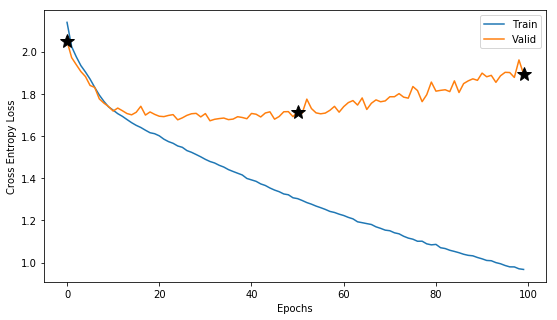

In [14]:
os.chdir(home_dir)
result_dir = home_dir + '/results/'
result_name = 'retrained_feedforward_'
ff.save_results(result_dir, result_name, untrained_model, snapshot_model, 
                forward_model, train_losses, val_losses, snapshot_epoch)

In [15]:
sample_idx = 45
predict_length = 30

filename_untrained = result_dir + result_name + 'untrained.mid'
ff.generate_melody(device, valid_set, sample_idx, untrained_model, predict_length, interval_range, filename_untrained)

filename_snapshot = result_dir + result_name + 'snapshot.mid'
ff.generate_melody(device, valid_set, sample_idx, snapshot_model, predict_length, interval_range, filename_snapshot)

filename_trained = result_dir + result_name + 'trained.mid'
ff.generate_melody(device, valid_set, sample_idx, forward_model, predict_length, interval_range, filename_trained)

In [16]:
import pygame

filename = filename_trained # or filename_trained or filename_snapshot
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [17]:
pygame.mixer.music.stop()

#### Loading the pretrained model and generating with it

In [18]:
import os
import torch
import src.feed_forward_utils as ff

try:
    home_dir
except NameError:
    home_dir = os.getcwd()
os.chdir(home_dir)

data_dir = '/data/raw/bach'

minibatch_size = 32
train_valid_ratio = 0.8        # size ratio of the train- and validation dataset
feature_qty = 10               # how many starter-intervals are presented to network
prediction_qty = 1             # must be one if intervals are used
interval_range = [-12, 12]     # in halftones -> 1 octave
snapshot_epoch = 50            # epoch at which a snapshot of the model is created during training

tracks = ff.load_tracks(data_dir, 1)
train_set, valid_set, train_loader, valid_loader = ff.generate_dataloaders(tracks, minibatch_size, train_valid_ratio, 
                                                                           feature_qty, prediction_qty, interval_range)

Loaded 357 tracks
Mean of the dataset: 0.00045936931473620525
Number of samples: 16490


In [22]:
os.chdir(home_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_filename = 'results/feedforward_trained.pth'
model_loaded = torch.load(model_filename)
model_loaded.to(device)
model_loaded.eval()

sample_idx = 42
predict_length = 25
result_dir = 'results'
result_name = 'loaded_feedforward_'
filename_loaded = result_dir + result_name + 'generating.mid'
ff.generate_melody(device, valid_set, sample_idx, model_loaded, predict_length, interval_range, filename_loaded)

In [23]:
import pygame

pygame.init()
pygame.mixer.music.load(filename_loaded)
pygame.mixer.music.play()

In [24]:
pygame.mixer.music.stop()

### **LSTMs**

### **Auto-Encoder**